In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
df = pd.read_csv('revenue_cleaned.csv')
melted = pd.melt(df, id_vars=['Cust_ID','Product Group'], var_name="Month", value_name="Revenue")

In [106]:
# Making the month columns into a date time object
melted['Month'] = pd.to_datetime(melted['Month'], format='%m/%d/%Y')
melted.dtypes

Cust_ID                  object
Product Group            object
Month            datetime64[ns]
Revenue                 float64
Year                      int64
dtype: object

In [14]:
# Adding Year for grouping 
melted = melted.sort_values(by='Month', ascending=True)
melted['Year'] = melted.Month.dt.year
melted.head()

,Cust_ID,Product Group,Month,Revenue,Year
0,CUSTOMER 1,FraudFinder 2.0.,2010-01-01,172.24,2010
3871,CUSTOMER 2761,FraudFinder 2.0.,2010-01-01,234.91,2010
1451,CUSTOMER 1037,FraudFinder,2010-01-01,49.21,2010
3869,CUSTOMER 2759,FraudFinder 2.0.,2010-01-01,0.00,2010
2905,CUSTOMER 2044,FraudFinder 2.0.,2010-01-01,0.00,2010


In [15]:
grouped = melted.groupby(['Product Group','Year']).sum()

In [18]:
grouped['pct_pop'] = grouped['Revenue'].pct_change()
grouped
# Nothing really new to see here

Revenue   pct_pop  pct_yoy
Product Group    Year                                
FraudFinder      2010   5500746.37       NaN      NaN
                 2011   4630352.42 -0.158232      NaN
                 2012   3436589.65 -0.257813      NaN
                 2013   1557334.17 -0.546837      NaN
FraudFinder 2.0. 2010   6956933.07  3.467206      NaN
                 2011   9496831.72  0.365089      NaN
                 2012  12131920.97  0.277470      NaN
                 2013   6674236.73 -0.449862      NaN
Other            2010    518072.34 -0.922377      NaN
                 2011    744834.01  0.437703      NaN
                 2012   1270390.13  0.705602      NaN
                 2013    892198.81 -0.297697      NaN

In [19]:
transmax = pd.read_csv('usage_cleaned.csv')
transmax.describe()

,# Transactions,Year
count,5.258000e+03,5258.000000
mean,9.404141e+05,2011.124572
std,1.257826e+07,0.802484
min,0.000000e+00,2010.000000
25%,5.650000e+01,2010.000000
50%,1.687800e+04,2011.000000
75%,1.918688e+05,2012.000000
max,8.021170e+08,2012.000000


In [107]:
# Maybe try removing some outliers?
outliers = transmax[transmax['# Transactions'] > transmax['# Transactions'].mean() + 3 * transmax['# Transactions'].std()]
outliers.Customer.unique()

array(['CUSTOMER 184', 'CUSTOMER 284', 'CUSTOMER 3040', 'CUSTOMER 3542',
       'CUSTOMER 3585', 'CUSTOMER 4038', 'CUSTOMER 319', 'CUSTOMER 774',
       'CUSTOMER 1773', 'CUSTOMER 2812'], dtype=object)

In [112]:
transmax2 = transmax[np.abs(transmax['# Transactions']-transmax['# Transactions'].mean()) <= (3*transmax['# Transactions'].std())]
transmax2.describe()
# Doesn't seem to do much

,# Transactions,Year
count,5.242000e+03,5242.000000
mean,5.220290e+05,2011.123998
std,2.092819e+06,0.802757
min,0.000000e+00,2010.000000
25%,5.400000e+01,2010.000000
50%,1.662100e+04,2011.000000
75%,1.883610e+05,2012.000000
max,3.708062e+07,2012.000000


In [113]:
# Get rid of columns where there were no transactions
transmax_nonull = transmax2.loc[transmax2['# Transactions']!=0]

In [114]:
years = transmax_nonull.Year.unique()
years

array([2010, 2011, 2012])

In [115]:
def topX(n, adf, asc, avg_tx):

    years = transmax.Year.unique()
    if asc == True:
        sort = 'Bottom'
    else:
        sort = 'Top'
    for item in years:
        cust = transmax.loc[transmax.Year==item].sort_values('# Transactions', ascending=asc)\
        [0:n].sort_values('# Transactions', ascending=asc)['Customer'].values
        
        selected = melted.loc[melted['Year']==item]
        adf[f'{item} {sort} {n}'] = selected.loc[selected['Cust_ID'].isin(cust)].groupby('Product Group')['Revenue'].mean()
    
        avg_tx.append(transmax.loc[transmax.Year==item].sort_values("# Transactions", ascending=asc)\
        [0:n]['# Transactions'].mean())
        
   


In [116]:
def revbyrank(adf, avg_tx):
    ranks = [10, 50, 100, 250]
    cond = [True, False]
    for con in cond:
        for item in ranks:
            topX(item, adf, con, avg_tx)
    return(adf, avg_tx)

In [117]:
adf = pd.DataFrame()
avg_tx = []

In [118]:
adf, avg_tx = revbyrank(adf, avg_tx)
adf 

,2010 Bottom 10,2011 Bottom 10,2012 Bottom 10,2010 Bottom 50,2011 Bottom 50,2012 Bottom 50,2010 Bottom 100,2011 Bottom 100,2012 Bottom 100,2010 Bottom 250,...,2012 Top 10,2010 Top 50,2011 Top 50,2012 Top 50,2010 Top 100,2011 Top 100,2012 Top 100,2010 Top 250,2011 Top 250,2012 Top 250
Product Group,,,,,,,,,,,,,,,,,,,,,
FraudFinder,76.033611,34.789375,31.681250,146.663095,79.825667,33.901806,130.727415,133.339889,48.172976,107.863451,...,384.995694,350.570238,366.701538,165.625000,267.193056,262.029574,104.347790,191.716650,164.292318,88.558307
FraudFinder 2.0.,103.121583,104.718917,133.025208,92.043850,113.087633,159.497011,84.299183,106.227308,354.521498,105.518199,...,3678.323917,798.515617,1113.005680,1817.420800,588.175308,872.374337,1390.108542,384.374069,602.224298,878.266690
Other,0.000000,-0.001389,0.000000,0.000000,24.496481,2.465583,1.875556,117.767051,-5.017197,40.593778,...,-185.826667,80.645064,220.938333,8.805641,61.948929,129.957982,5.203333,57.319444,73.500154,158.675985


In [55]:
# b10 = adf[['2010 Bottom 10', '2011 Bottom 10', '2012 Bottom 10']].mean(axis=1)
# b50 = adf[['2010 Bottom 50', '2011 Bottom 50', '2012 Bottom 50']].mean(axis=1)
# b100 = adf[['2010 Bottom 100', '2011 Bottom 100', '2012 Bottom 100']].mean(axis=1)
# b250 = adf[['2010 Bottom 250', '2011 Bottom 250', '2012 Bottom 250']].mean(axis=1)
# t10 = adf[['2010 Top 10', '2011 Top 10', '2012 Top 10']].mean(axis=1)
# t50 = adf[['2010 Top 50', '2011 Top 50', '2012 Top 50']].mean(axis=1)
# t100 = adf[['2010 Top 100', '2011 Top 100', '2012 Top 100']].mean(axis=1)
# t250 = adf[['2010 Top 250', '2011 Top 250', '2012 Top 250']].mean(axis=1)

In [119]:
adf = adf.transpose()

In [120]:
adf['Mean Max Trans'] = avg_tx
adf

Product Group,FraudFinder,FraudFinder 2.0.,Other,Mean Max Trans
2010 Bottom 10,76.033611,103.121583,0.000000,0.000000e+00
2011 Bottom 10,34.789375,104.718917,-0.001389,0.000000e+00
2012 Bottom 10,31.681250,133.025208,0.000000,0.000000e+00
2010 Bottom 50,146.663095,92.043850,0.000000,0.000000e+00
2011 Bottom 50,79.825667,113.087633,24.496481,0.000000e+00
2012 Bottom 50,33.901806,159.497011,2.465583,0.000000e+00
2010 Bottom 100,130.727415,84.299183,1.875556,0.000000e+00
2011 Bottom 100,133.339889,106.227308,117.767051,0.000000e+00
2012 Bottom 100,48.172976,354.521498,-5.017197,0.000000e+00
2010 Bottom 250,107.863451,105.518199,40.593778,0.000000e+00


In [102]:
# df2= pd.concat([b10, b50, b100, b250, t10, t50, t100, t250], axis=1, names=['Bottom 10', 'Bottom 50', 'Bottom 100','Bottom 250','Top 10', 'Top 50', 'Top 100', 'Top 250'])
# df2 = df2.rename(columns={0:'Bottom 10', 1:'Bottom 50', 2:'Bottom 100',3:'Bottom 250',4:'Top 10', 5:'Top 50', 6:'Top 100',7:'Top 250'})
# df2

In [103]:
# df2 = df2.transpose()
# len(df2)

In [104]:
# arr = np.arange(0, len(avg_tx)+3, 3)
# sets = []
# for i in range(len(arr)-1):
#     sets.append(np.mean(avg_tx[arr[i]:arr[i+1]]))
# df2['Mean Transaction Max'] = sets
# df2

/Users/laura/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


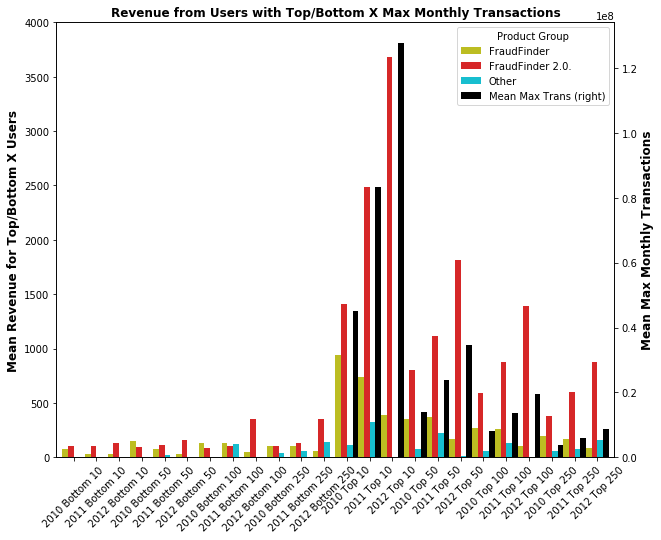

In [122]:
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'ylim':(0,4000)})
ax = adf.plot(ax=ax, secondary_y=['Mean Max Trans'], kind='bar', figsize=(10,8), legend=True, colors=['tab:olive','tab:red','tab:cyan','black'], rot=45, width=1)
ax.right_ax.set_ylabel('Mean Max Monthly Transactions', fontsize=12, fontweight='bold')
ax.set_ylabel("Mean Revenue for Top/Bottom X Users", fontsize=12, fontweight='bold')
plt.xlabel('Revenue from Top/Bottom X Users per Year', fontsize=12, fontweight='bold')
plt.title('Revenue from Users with Top/Bottom X Max Monthly Transactions', fontsize=12, fontweight='bold')

plt.savefig('./revenue_summary2.png',transparent=False, dpi=80, bbox_inches="tight")

In [195]:
melted_pos = melted.loc[melted.Revenue !=0]

In [204]:
df1 = melted_pos.merge(transmax, left_on=['Cust_ID'], right_on=['Customer'])
df1.head()

,Cust_ID,Product Group,Month,Revenue,Year_x,Customer,# Transactions,Year_y
0,CUSTOMER 2761,FraudFinder 2.0.,2010-01-01,234.91,2010,CUSTOMER 2761,321684,2010
1,CUSTOMER 2761,FraudFinder 2.0.,2010-01-01,234.91,2010,CUSTOMER 2761,253958,2011
2,CUSTOMER 2761,FraudFinder 2.0.,2010-01-01,234.91,2010,CUSTOMER 2761,377323,2012
3,CUSTOMER 2761,FraudFinder 2.0.,2010-02-01,234.91,2010,CUSTOMER 2761,321684,2010
4,CUSTOMER 2761,FraudFinder 2.0.,2010-02-01,234.91,2010,CUSTOMER 2761,253958,2011


In [205]:
df1.drop_duplicates(keep='first', inplace=True)
len(df1)

205069

In [206]:
df1 = df1[df1['Year_x'] == df1['Year_y']]
df1 = df1.drop(columns=['Customer','Year_y'], axis=1)
df1 = df1.rename(columns={'Year_x':'Year'})

In [207]:
df1 = df1.groupby(['Cust_ID','Product Group','Year']).sum()
len(df1)

6336

In [208]:
df1 = df1.reset_index()

In [219]:
df1.loc[df1['Revenue']==0]
# There seem to be a number of clients who weren't paying but still are logging transactions

,Cust_ID,Product Group,Year,Revenue,# Transactions
1512,CUSTOMER 188,FraudFinder 2.0.,2011,0.0,0
1822,CUSTOMER 2053,FraudFinder 2.0.,2012,0.0,306369
4541,CUSTOMER 3721,FraudFinder 2.0.,2011,0.0,364089
4715,CUSTOMER 3810,FraudFinder 2.0.,2011,0.0,94594
4843,CUSTOMER 3876,FraudFinder,2012,0.0,732146
5266,CUSTOMER 4145,FraudFinder,2012,0.0,674174


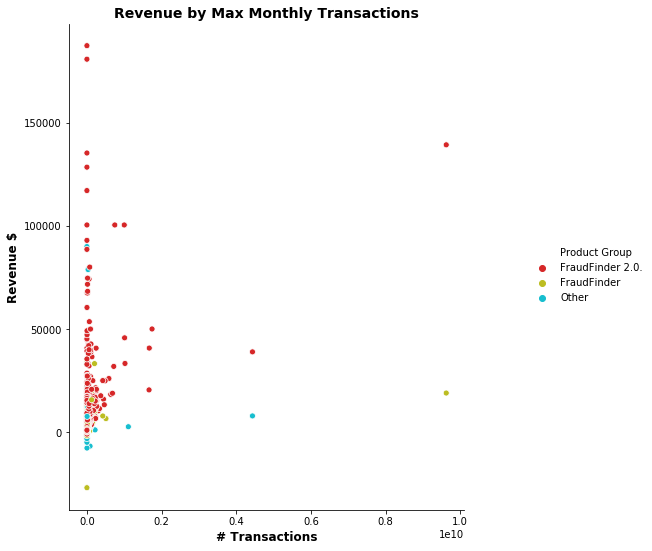

In [221]:
colors = ['tab:red','tab:olive','tab:cyan']
sns.set_palette(colors)

sns.relplot(y='Revenue', x='# Transactions', data=df1, hue='Product Group')
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.title(f"Revenue by Max Monthly Transactions", fontsize=14, fontweight='bold')
plt.xlabel('# Transactions', fontsize=12, fontweight='bold')
plt.ylabel('Revenue $', fontsize=12, fontweight='bold')

plt.savefig('rev_x_transact.png')

In [223]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df1['# Transactions'], df1['Revenue'])
s_stats = f'Slope: {slope}. Intercept: {intercept}. R: {r_value}. P: {p_value}. SE: {std_err}'
s_stats

'Slope: 9.79514824111895e-06. Intercept: 2827.104515148366. R: 0.26021652369488113. P: 1.4093397394499485e-98. SE: 4.566800196267663e-07'

In [225]:
df3 = df1.loc[df1['# Transactions'] != 0]
df_ff2 = df3.loc[df3['Product Group'] == 'FraudFinder 2.0.']
df_ff = df3.loc[df3['Product Group'] == 'FraudFinder']
df_o = df3.loc[df3['Product Group'] == 'Other']

No handles with labels found to put in legend.


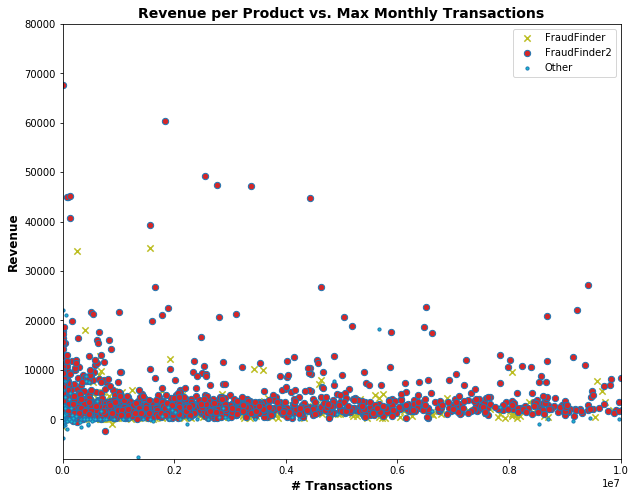

In [226]:
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'ylim':(-8000,80000), 'xlim':(0,10000000)})
plt.xlabel('Transactions', fontsize=12, fontweight='bold')
plt.ylabel('Revenue', fontsize=12, fontweight='bold')
plt.title(f"Revenue per Product vs. Max Monthly Transactions", fontsize=14, fontweight='bold')
plt.legend(loc='best')
df_ff.plot(ax=ax, kind="scatter", grid=False, x='# Transactions',y="Revenue", s=40, color="tab:olive", edgecolors="tab:blue", marker='x', label='FraudFinder')
df_ff2.plot(ax=ax, kind="scatter", grid=False, x='# Transactions',y="Revenue", s=40, color="tab:red", edgecolors="tab:blue", marker='o', label='FraudFinder2')
df_o.plot(ax=ax, kind="scatter", grid=False, x='# Transactions',y="Revenue", s=40, color="tab:cyan", edgecolors="tab:blue", marker='.', label='Other')
plt.savefig('revtrans.png')

In [229]:
sum_revenue_transnulls = df1.loc[df1['# Transactions']==0]

In [235]:
# Amount of revenue at risk
sum_revenue_transnulls.groupby('Year')['Revenue'].sum()

Year
2010     530232.01
2011     684852.87
2012    1311458.63
Name: Revenue, dtype: float64